In [1]:
from pathlib import Path
import logging

from mordred import Calculator, descriptors
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, rdFingerprintGenerator, Draw
from rdkit.Chem import SaltRemover

from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from pandas import Series
import seaborn as sns
import colorcet as cc
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
tqdm.pandas()

In [3]:
logger = logging.getLogger(__name__)

formatter = logging.Formatter(
    "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
ch = logging.StreamHandler()
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.setLevel(logging.INFO)


In [4]:
# project data root directory
base_data_dir = Path().cwd().parents[0] / "assets/dataset/raw"

if not base_data_dir.exists():
    raise FileNotFoundError(f"Data directory not found at {base_data_dir}")


In [5]:
def canonicalize_smiles(smiles: str, isomeric: bool = True) -> str:
    """Convert SMILES string to its canonical form.

    Args:
        smiles (str): Input SMILES string.

    Returns:
        str: Canonical SMILES string.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        logger.warning(f"Invalid SMILES string: {smiles}")
        return None
    
    # remove salts and invalid molecules
    remover = SaltRemover.SaltRemover()
    mol = remover.StripMol(mol, dontRemoveEverything=True)
    if mol.GetNumAtoms() == 0:
        logger.warning(f"SMILES string resulted in empty molecule after salt removal: {smiles}")
        return None
    
    # return canonical SMILES
    smi = Chem.MolToSmiles(mol, canonical=True, isomericSmiles=isomeric, doRandom=False)
    return smi

## Challenge Data: ExpansionRX

In [6]:
cleaned_data = {}

In [7]:
cols_with_units = {
    "LogD": "(None)",
    "KSOL": "(uM)",
    "HLM CLint": "(mL/min/kg)",
    "MLM CLint": "(mL/min/kg)",
    "Caco-2 Permeability Papp A>B": "(10^-6 cm/s)",
    "Caco-2 Permeability Efflux": "(None)",
    "MPPB": "(% unbound)",
    "MBPB": "(% unbound)",
    "MGMB": "(% unbound)",
}

transformations = {
    "None": lambda x: x,
    "10^(x+6)": lambda x: 10.0 ** (x + 6.0),
    "10^(x)": lambda x: 10.0 ** (x),
}

In [8]:
# load data
df_expansionrx_teaser = pd.read_csv(base_data_dir / "ExpansionRX/expansion_teaser.csv")

# rename cols to have units
df_expansionrx_teaser.rename(
    columns={k: f"{k} {v}" for k, v in cols_with_units.items()},
    inplace=True,
)

# drop rows with invalid SMILES
df_expansionrx_teaser["SMILES"] = df_expansionrx_teaser["SMILES"].apply(canonicalize_smiles)
n_none_smiles = df_expansionrx_teaser["SMILES"].isnull().sum()
if n_none_smiles > 0:
    logger.warning(f"Dropping {n_none_smiles} rows with invalid SMILES")
    df_expansionrx_teaser.dropna(subset=["SMILES"], inplace=True)
    df_expansionrx_teaser.reset_index(drop=True, inplace=True)

logger.info(f"Dataframe shape: {df_expansionrx_teaser.shape}")
logger.info(f"Dataframe columns: {df_expansionrx_teaser.columns.tolist()}")

2025-10-25 09:28:50,361 - __main__ - INFO - Dataframe shape: (532, 11)
2025-10-25 09:28:50,361 - __main__ - INFO - Dataframe columns: ['Molecule Name', 'SMILES', 'LogD (None)', 'KSOL (uM)', 'HLM CLint (mL/min/kg)', 'MLM CLint (mL/min/kg)', 'Caco-2 Permeability Papp A>B (10^-6 cm/s)', 'Caco-2 Permeability Efflux (None)', 'MPPB (% unbound)', 'MBPB (% unbound)', 'MGMB (% unbound)']


In [9]:
cleaned_data["expansionrx_teaser"] = df_expansionrx_teaser.copy()

In [10]:
def calc_stats(series: Series) -> str:
    """
    Calculate summary statistics for a pandas Series and format as a string.

    Parameters
    ----------
    series : pandas.Series
        Numeric column to summarize.

    Returns
    -------
    str
        Formatted string with min, max, mean, median, std, skew, kurtosis, and count.
    """
    array = series.dropna().to_numpy()
    
    # calc min, max, median, mean, std, skew, kurtosis, count
    out = {
        "min": np.min(array),
        "max": np.max(array),
        "mean": np.mean(array),
        "median": np.median(array),
        "std": np.std(array, ddof=1),
        "skew": stats.skew(array),
        "kurtosis": stats.kurtosis(array),
        "count": len(array),
    }
    stats_str = (
        f"min: {out['min']:.4g}\n"
        f"max: {out['max']:.4g}\n"
        f"mean: {out['mean']:.4g}\n"
        f"median: {out['median']:.4g}\n"
        f"std: {out['std']:.4g}\n"
        f"skew: {out['skew']:.4g}\n"
        f"kurtosis: {out['kurtosis']:.4g}\n"
        f"count: {out['count']}"
    )
    return stats_str


/Users/alecglisman/Library/CloudStorage/Dropbox/Hobby/OpenADMET-Challenge/venv/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/alecglisman/Library/CloudStorage/Dropbox/Hobby/OpenADMET-Challenge/venv/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


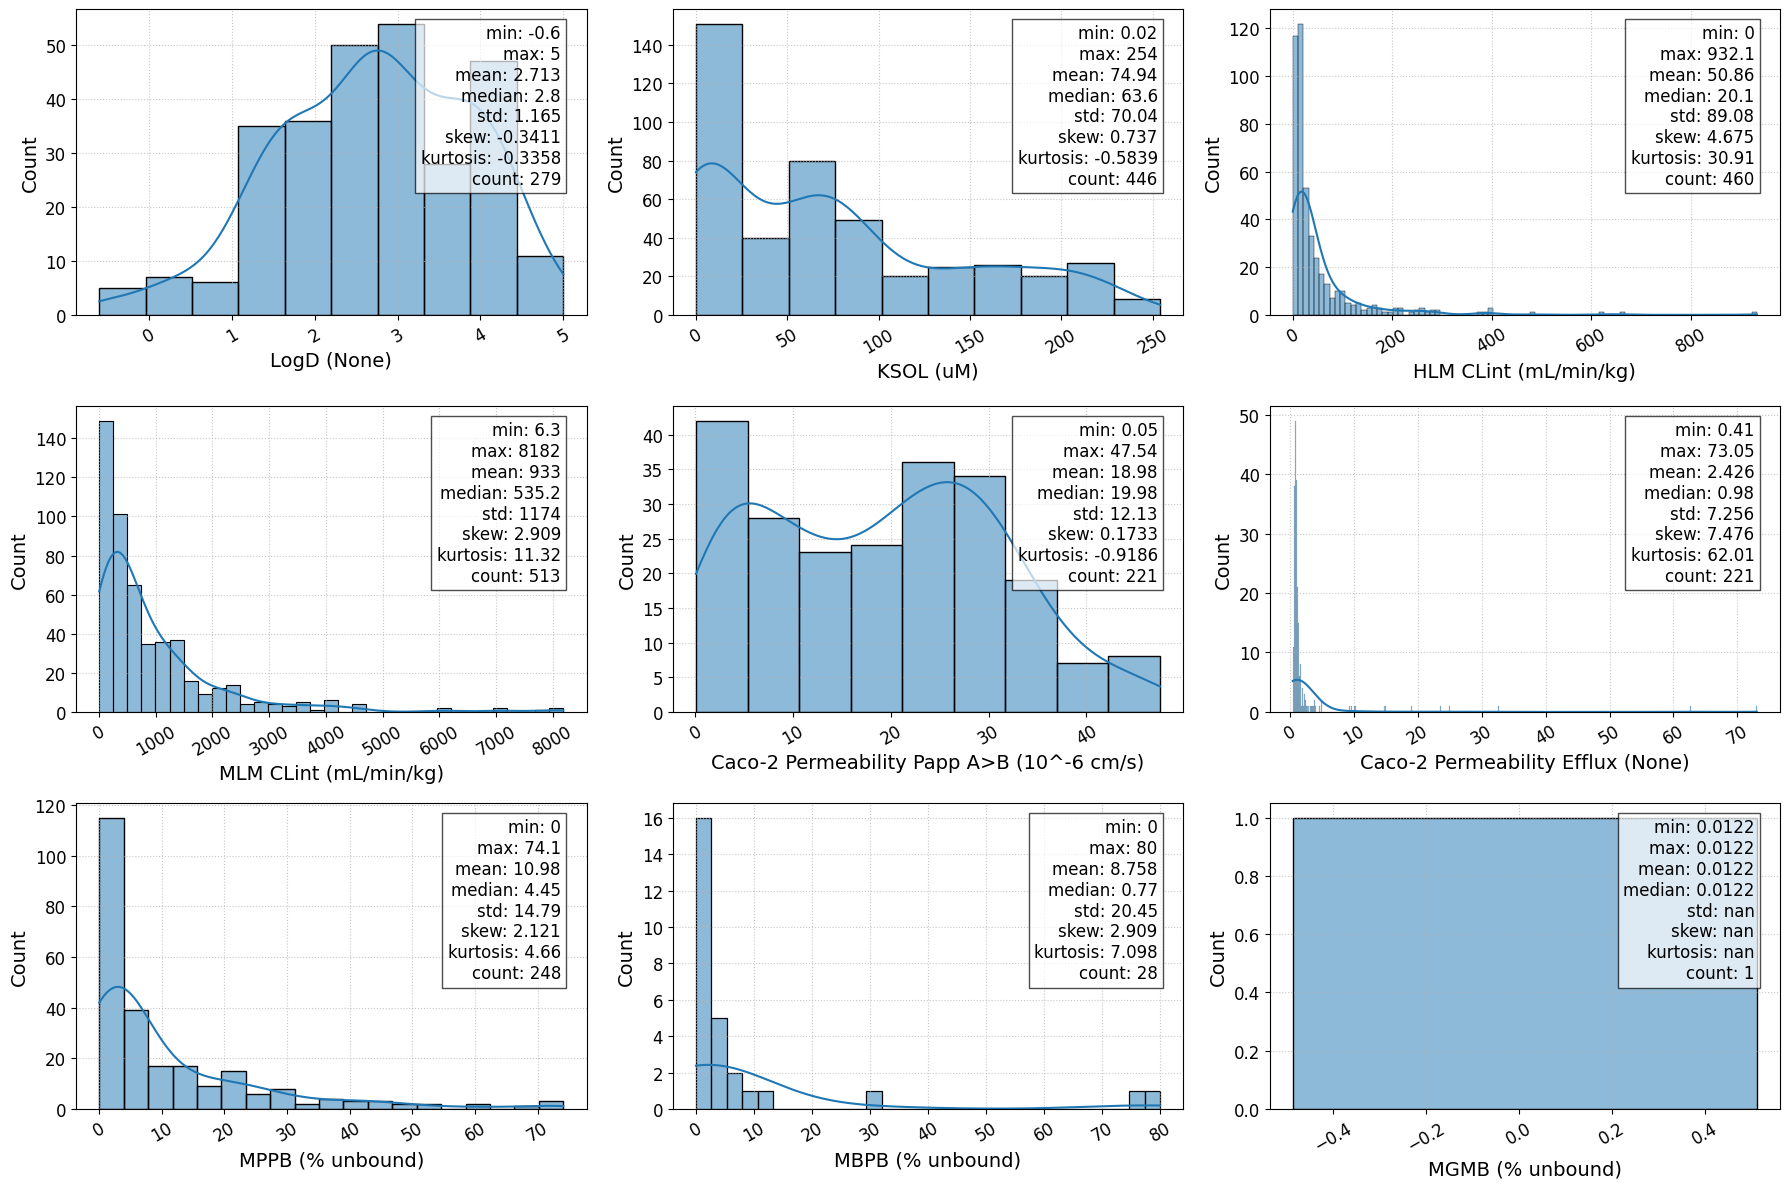

In [11]:
# Plot distributions for each numeric column with summary statistics in a 3-column grid
numeric_cols = df_expansionrx_teaser.select_dtypes(include=["number"]).columns
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()
i = -1
for i, col in enumerate(numeric_cols):
    ax = axes[i]
    sns.histplot(df_expansionrx_teaser[col], kde=True, ax=ax)
    stat_text = calc_stats(df_expansionrx_teaser[col])
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.grid(True, linestyle=":", alpha=0.7)
    ax.tick_params(axis='x', labelrotation=30, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.text(
        0.95,
        0.95,
        stat_text,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="black"),
    )
# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
fig.tight_layout()

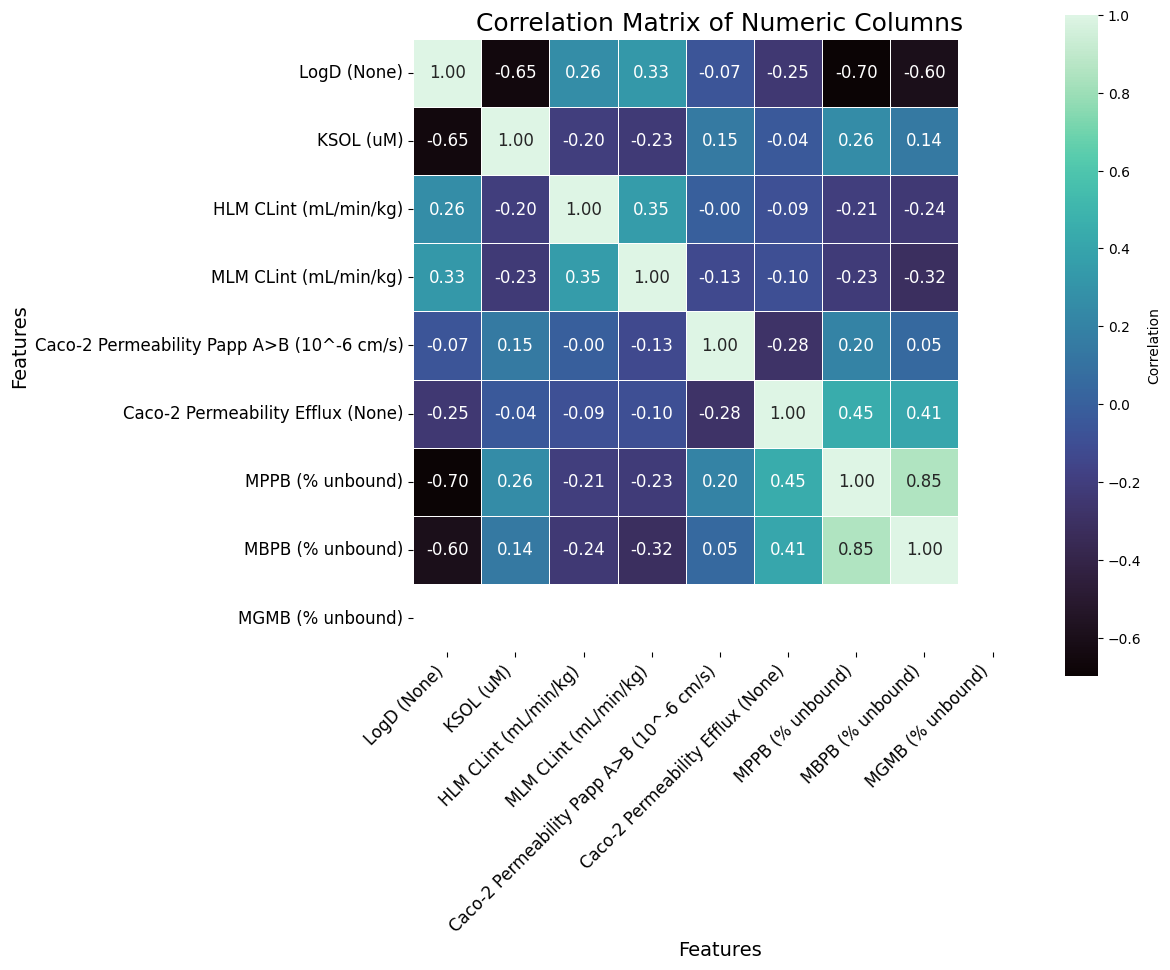

In [12]:
corr = df_expansionrx_teaser[numeric_cols].corr()
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
sns.heatmap(
    corr,
    annot=True,
    cmap="mako",
    fmt=".2f",
    ax=ax,
    square=True,
    cbar_kws={"label": "Correlation"},
    linewidths=0.5,
    linecolor="white",
    annot_kws={"size": 12},
)
ax.set_title("Correlation Matrix of Numeric Columns", fontsize=18)
ax.set_xlabel("Features", fontsize=14)
ax.set_ylabel("Features", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
fig.tight_layout()

## KERMT Dataset

### Public

In [13]:
files_biogen = [
    "KERMT/export_public_cluster_split/all_test_cluster_morgan.csv",
    "KERMT/export_public_cluster_split/all_train_fold_0_cluster_morgan.csv",
    "KERMT/export_public_cluster_split/all_val_fold_0_cluster_morgan.csv",
]

df_kermt_public = pd.DataFrame()
for f in files_biogen:
    df = pd.read_csv(base_data_dir / f)
    df["file"] = f
    df_kermt_public = pd.concat([df_kermt_public, df], ignore_index=True)

# rename smiles --> SMILES
df_kermt_public.rename(columns={"smiles": "SMILES"}, inplace=True)

# drop rows with invalid SMILES
df_kermt_public["SMILES"] = df_kermt_public["SMILES"].progress_apply(canonicalize_smiles)
n_none_smiles = df_kermt_public["SMILES"].isnull().sum()
if n_none_smiles > 0:
    logger.warning(f"Dropping {n_none_smiles} rows with invalid SMILES")
    df_kermt_public.dropna(subset=["SMILES"], inplace=True)
    df_kermt_public.reset_index(drop=True, inplace=True)

logger.info(f"KERMT Public Dataframe shape: {df_kermt_public.shape}")
logger.info(f"KERMT Public Dataframe columns: {df_kermt_public.columns.tolist()}")

# print finite number of entries for each column
for col in df_kermt_public.columns:
    if not pd.api.types.is_numeric_dtype(df_kermt_public[col]):
        continue
    n_finite = np.isfinite(df_kermt_public[col]).sum()
    logger.info(f"Column '{col}' has {n_finite} finite entries out of {len(df_kermt_public)}")

  0%|          | 0/114112 [00:00<?, ?it/s]

2025-10-25 09:30:48,218 - __main__ - INFO - KERMT Public Dataframe shape: (114112, 27)
2025-10-25 09:30:48,218 - __main__ - INFO - KERMT Public Dataframe columns: ['SMILES', 'CL_microsome_human', 'CL_microsome_mouse', 'CL_microsome_rat', 'CL_total_dog', 'CL_total_human', 'CL_total_monkey', 'CL_total_rat', 'CYP2C8_inhibition', 'CYP2C9_inhibition', 'CYP2D6_inhibition', 'CYP3A4_inhibition', 'Dog_fraction_unbound_plasma', 'Human_fraction_unbound_plasma', 'Monkey_fraction_unbound_plasma', 'Rat_fraction_unbound_plasma', 'Papp_Caco2', 'Pgp_human', 'hERG_binding', 'LogD_pH_7.4', 'kinetic_logSaq', 'thermo_logSaq', 'VDss_dog', 'VDss_human', 'VDss_monkey', 'VDss_rat', 'file']
2025-10-25 09:30:48,220 - __main__ - INFO - Column 'CL_microsome_human' has 5218 finite entries out of 114112
2025-10-25 09:30:48,221 - __main__ - INFO - Column 'CL_microsome_mouse' has 663 finite entries out of 114112
2025-10-25 09:30:48,223 - __main__ - INFO - Column 'CL_microsome_rat' has 1798 finite entries out of 114112

In [14]:
# map from KERMT data to ExpansionRX data on SMILES
map_cols_kermt_to_expansionrx = [
    {
        "input_col": "LogD_pH_7.4",
        "output_col": "LogD (None)",
        "transform": transformations["None"],
    },
    {
        "input_col": "kinetic_logSaq",  # log(M)
        "output_col": "KSOL (uM)",
        "transform": transformations["10^(x+6)"],
    },
    {
        "input_col": "CL_microsome_human",  # log(mL/min/mg)
        "output_col": "HLM CLint (mL/min/kg)",
        "transform": transformations["10^(x)"],
    },
    {
        "input_col": "CL_microsome_mouse",  # log(mL/min/mg)
        "output_col": "MLM CLint (mL/min/kg)",
        "transform": transformations["10^(x)"],
    },
    {
        "input_col": "Papp_Caco2",  # log(10^-6 cm/sec)
        "output_col": "Caco-2 Permeability Papp A>B (10^-6 cm/s)",
        "transform": transformations["10^(x)"],
    },
    {
        # REVIEW: low confidence mapping
        "input_col": "Pgp_human",  # log(None)
        "output_col": "Caco-2 Permeability Efflux (None)",
        "transform": transformations["10^(x)"],
    },
]

df_kermt_public_admet_cleaned = df_kermt_public[["SMILES"]]
for mapping in map_cols_kermt_to_expansionrx:
    input_col = mapping["input_col"]
    output_col = mapping["output_col"]
    transform = mapping["transform"]

    df_input = df_kermt_public[["SMILES", input_col]].copy()
    df_input[output_col] = df_input[input_col].apply(transform).copy()
    df_input.drop(columns=[input_col], inplace=True)

    df_kermt_public_admet_cleaned = pd.merge(df_kermt_public_admet_cleaned, df_input, on="SMILES")

In [15]:
# limit KSol to < 250
idx_infinite_ksol = df_kermt_public_admet_cleaned["KSOL (uM)"].isnull()
idx_too_large = df_kermt_public_admet_cleaned["KSOL (uM)"] > 250.0
idx_remove = ~idx_infinite_ksol & idx_too_large
df_kermt_public_admet_cleaned = df_kermt_public_admet_cleaned[~idx_remove].reset_index(drop=True)

# limit Caco-2 Permeability Papp A>B to < 100
idx_infinite_caco2 = df_kermt_public_admet_cleaned["Caco-2 Permeability Papp A>B (10^-6 cm/s)"].isnull()
idx_too_large_caco2 = df_kermt_public_admet_cleaned["Caco-2 Permeability Papp A>B (10^-6 cm/s)"] > 100.0
idx_remove_caco2 = ~idx_infinite_caco2 & idx_too_large_caco2
df_kermt_public_admet_cleaned = df_kermt_public_admet_cleaned[~idx_remove_caco2].reset_index(drop=True)

# limit Caco-2 Permeability Efflux to < 100
idx_infinite_efflux = df_kermt_public_admet_cleaned["Caco-2 Permeability Efflux (None)"].isnull()
idx_too_large_efflux = df_kermt_public_admet_cleaned["Caco-2 Permeability Efflux (None)"] > 100.0
idx_remove_efflux = ~idx_infinite_efflux & idx_too_large_efflux
df_kermt_public_admet_cleaned = df_kermt_public_admet_cleaned[~idx_remove_efflux].reset_index(drop=True)

# drop rows with all NaN values across ADMET columns
admet_cols = [mapping["output_col"] for mapping in map_cols_kermt_to_expansionrx]
df_kermt_public_admet_cleaned.dropna(subset=admet_cols, how="all", inplace=True)
df_kermt_public_admet_cleaned.reset_index(drop=True, inplace=True)

logger.info(f"Merged KERMT-ExpansionRX Dataframe shape: {df_kermt_public_admet_cleaned.shape}")
logger.info(f"Merged KERMT-ExpansionRX Dataframe columns: {df_kermt_public_admet_cleaned.columns.tolist()}")

2025-10-25 09:30:49,038 - __main__ - INFO - Merged KERMT-ExpansionRX Dataframe shape: (91556, 7)
2025-10-25 09:30:49,039 - __main__ - INFO - Merged KERMT-ExpansionRX Dataframe columns: ['SMILES', 'LogD (None)', 'KSOL (uM)', 'HLM CLint (mL/min/kg)', 'MLM CLint (mL/min/kg)', 'Caco-2 Permeability Papp A>B (10^-6 cm/s)', 'Caco-2 Permeability Efflux (None)']


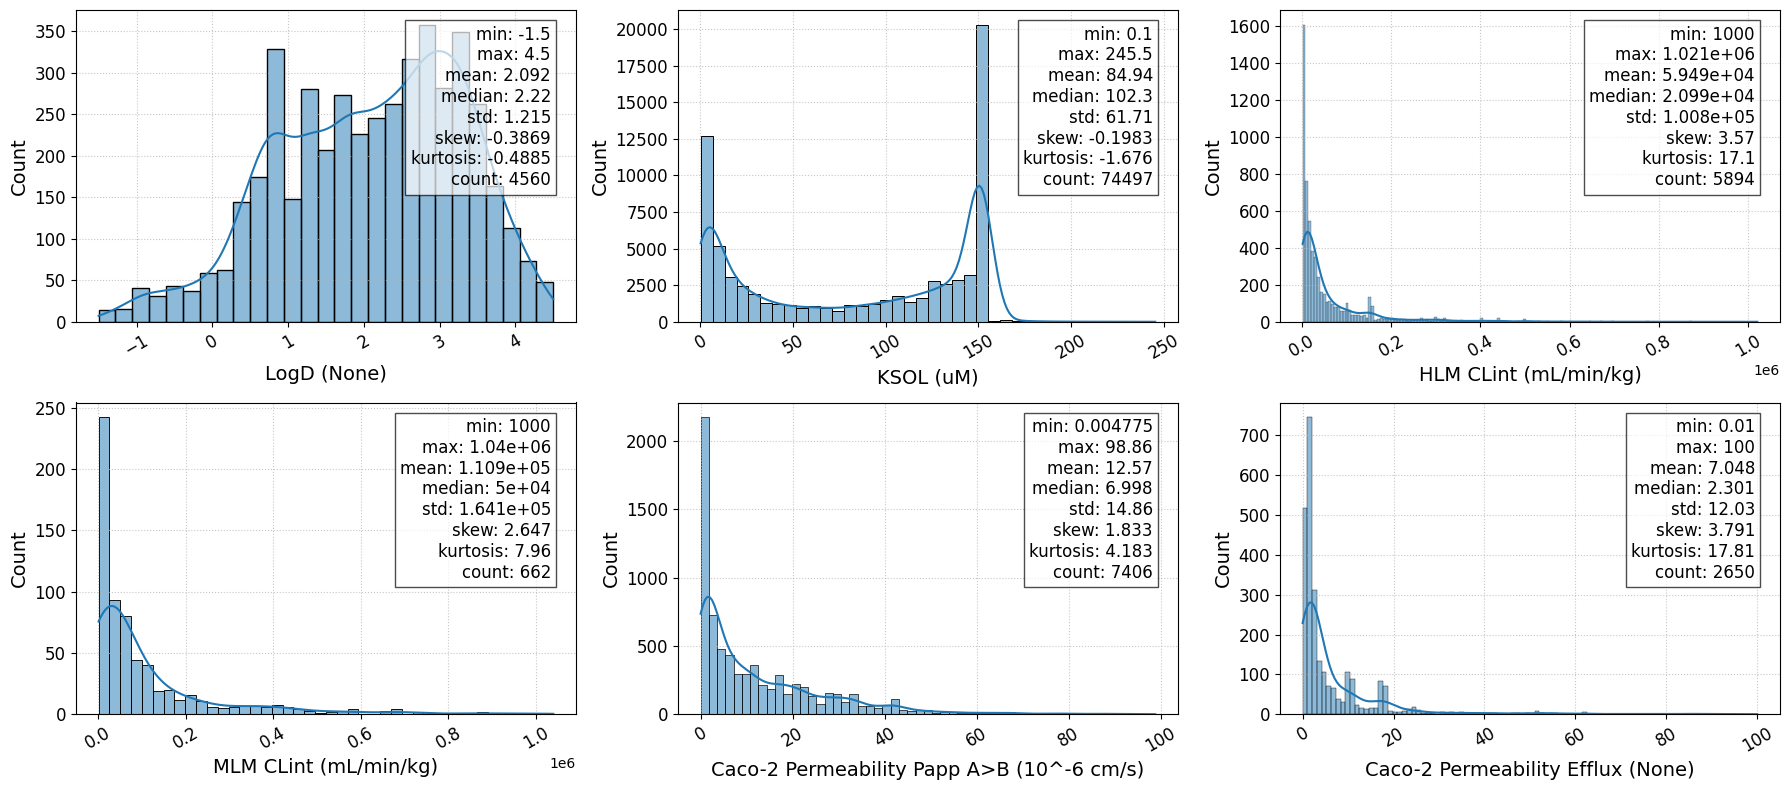

In [16]:
# Plot distributions for each numeric column with summary statistics in a 3-column grid
df = df_kermt_public_admet_cleaned
numeric_cols = df.select_dtypes(include=["number"]).columns
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()
i = -1
for i, col in enumerate(numeric_cols):
    ax = axes[i]
    sns.histplot(df[col], kde=True, ax=ax)
    stat_text = calc_stats(df[col])
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.grid(True, linestyle=":", alpha=0.7)
    ax.tick_params(axis="x", labelrotation=30, labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.text(
        0.95,
        0.95,
        stat_text,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="black"),
    )
# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")
fig.tight_layout()

In [17]:
cleaned_data["kermt_public"] = df_kermt_public_admet_cleaned.copy()

In [18]:
files_biogen = [
    "KERMT/export_biogen_cluster_split/all_test_cluster_morgan.csv",
    "KERMT/export_biogen_cluster_split/all_train_fold_0_cluster_morgan.csv",
    "KERMT/export_biogen_cluster_split/all_val_fold_0_cluster_morgan.csv",
]

df_kermt_biogen = [pd.read_csv(base_data_dir / file) for file in files_biogen]
df_kermt_biogen = pd.concat(df_kermt_biogen, ignore_index=True)
logger.info(f"KERMT Biogen Dataframe shape: {df_kermt_biogen.shape}")
logger.info(f"KERMT Biogen Dataframe columns: {df_kermt_biogen.columns.tolist()}")

2025-10-25 09:30:51,632 - __main__ - INFO - KERMT Biogen Dataframe shape: (3521, 7)
2025-10-25 09:30:51,633 - __main__ - INFO - KERMT Biogen Dataframe columns: ['smiles', 'HLM_CLint', 'MDR1-MDCK_ER', 'SOLY_6.8', 'Human_fraction_unbound_plasma', 'Rat_fraction_unbound_plasma', 'RLM_Clint']


### Biogen

## Final

In [19]:
# Save all cleaned datasets as a single dataframe with column for dataset name
df_out = pd.DataFrame()
for name, df in cleaned_data.items():
    df_temp = df.copy()
    df_temp["dataset"] = name
    df_out = pd.concat([df_out, df_temp], axis=0)
    
df_out.reset_index(drop=True, inplace=True)
output_path = base_data_dir.parent / "cleaned_combined_datasets.csv"
df_out.to_csv(output_path, index=False)

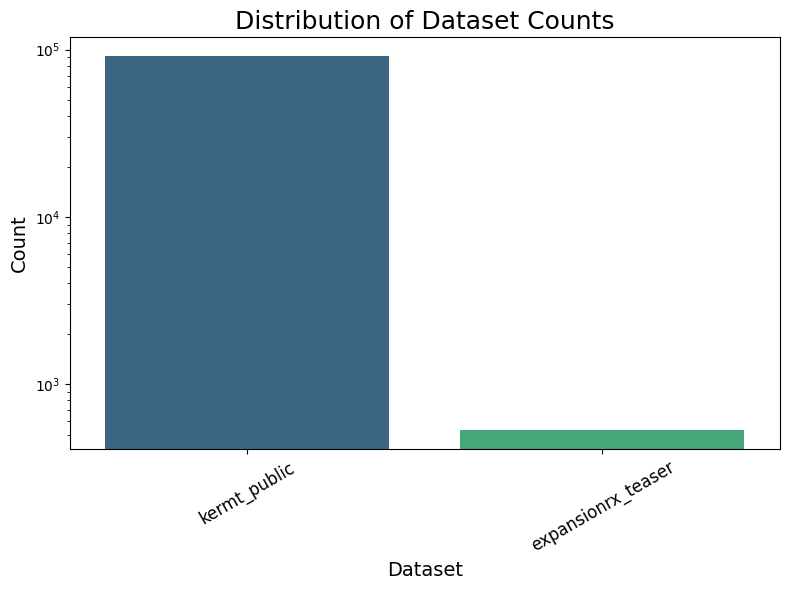

In [ ]:
# plot the distribution of dataset counts
dataset_counts = df_out["dataset"].value_counts()
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(
    x=dataset_counts.index,
    y=dataset_counts.values,
    ax=ax,
    palette="viridis",
    hue=dataset_counts.index,
    dodge=False,
)
ax.set_xlabel("Dataset", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_title("Distribution of Dataset Counts", fontsize=18)
ax.tick_params(axis="x", labelrotation=30, labelsize=12)
ax.set_yscale("log")
fig.tight_layout()

# save al 